## Loading the Data

In [79]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [83]:
df = pd.read_csv("sample.csv")

In [84]:
print(df.info())
print("\nFirst 5 Rows")
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3159 entries, 0 to 3158
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    3159 non-null   object 
 1   Value   3159 non-null   float64
dtypes: float64(1), object(1)
memory usage: 49.5+ KB
None

First 5 Rows
                        time     Value
0  2020-07-31 22:42:40+00:00  0.723186
1  2020-07-31 22:52:36+00:00  0.724480
2  2020-07-31 23:02:28+00:00  0.707017
3  2020-07-31 23:12:35+00:00  0.725666
4  2020-07-31 23:22:32+00:00  0.708526


In [85]:
df["time"] = pd.to_datetime(df["time"], infer_datetime_format=True, utc=True)
df = df.sort_values(by="time").reset_index(drop=True)

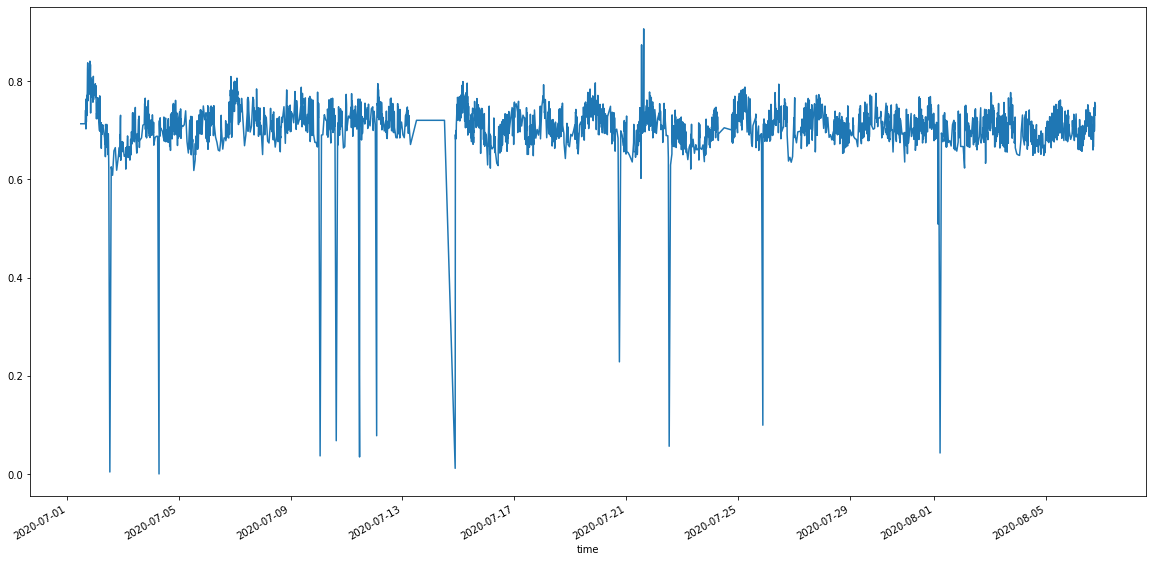

In [86]:
df = df.set_index(df["time"])
df["Value"].plot(figsize=(20,10))

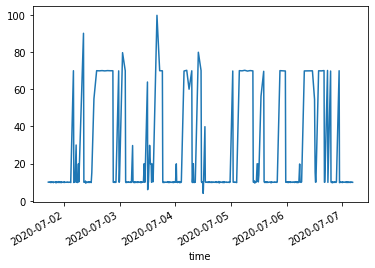

In [87]:
(df["time"].diff() / pd.Timedelta("1m")).iloc[10:500].plot()

## Regularize Time Series Data

In [88]:
from datetime import timedelta
import matplotlib.pyplot as plt

# https://github.com/datascopeanalytics/traces
import traces

In [89]:
def round_time(dt, nearest_min):
    dt += timedelta(minutes=nearest_min/2)
    dt -= timedelta(minutes=dt.minute % nearest_min,
                    seconds=dt.second,
                    microseconds=dt.microsecond)
    
    return dt

In [90]:
time_start = round_time(df['time'].min(), nearest_min=10)
time_end = round_time(df['time'].max(), nearest_min=10)

ts = traces.TimeSeries(list(zip(df['time'], df["Value"])))

print("Regularize from: {}, to: {}".format(time_start, time_end))

Regularize from: 2020-07-01 12:00:00+00:00, to: 2020-08-06 18:30:00+00:00


In [91]:
ts_regular = ts.moving_average(
    sampling_period=600, #seconds
    window_size=600,   #seconds
    pandas=True,
    start=time_start
)

df_regular = pd.DataFrame(ts_regular)
df_regular.index.name = 'time'
df_regular = df_regular.rename(columns={0: "Value"})
df_regular = df_regular.dropna().reset_index()

In [92]:
df_regular = df_regular.set_index(df_regular["time"])

In [93]:
df_regular.head()

,time,Value
time,,
2020-07-01 12:00:00+00:00,2020-07-01 12:00:00+00:00,0.713269
2020-07-01 12:10:00+00:00,2020-07-01 12:10:00+00:00,0.713269
2020-07-01 12:20:00+00:00,2020-07-01 12:20:00+00:00,0.713269
2020-07-01 12:30:00+00:00,2020-07-01 12:30:00+00:00,0.713269
2020-07-01 12:40:00+00:00,2020-07-01 12:40:00+00:00,0.713269


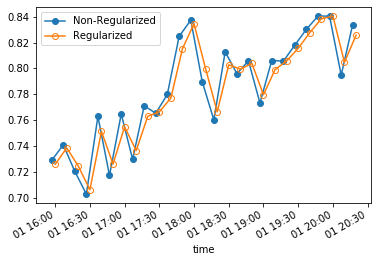

In [94]:
df["Value"][2:29].plot(marker="o", label="Non-Regularized")
df_regular["Value"][24:51].plot(marker="o", fillstyle="none", label="Regularized")
plt.legend()

## Signal Matching
Suppose we are interested in finding similar sequences as below:

In [95]:
import numpy as np
import time

# https://github.com/wannesm/dtaidistance
from dtaidistance import dtw

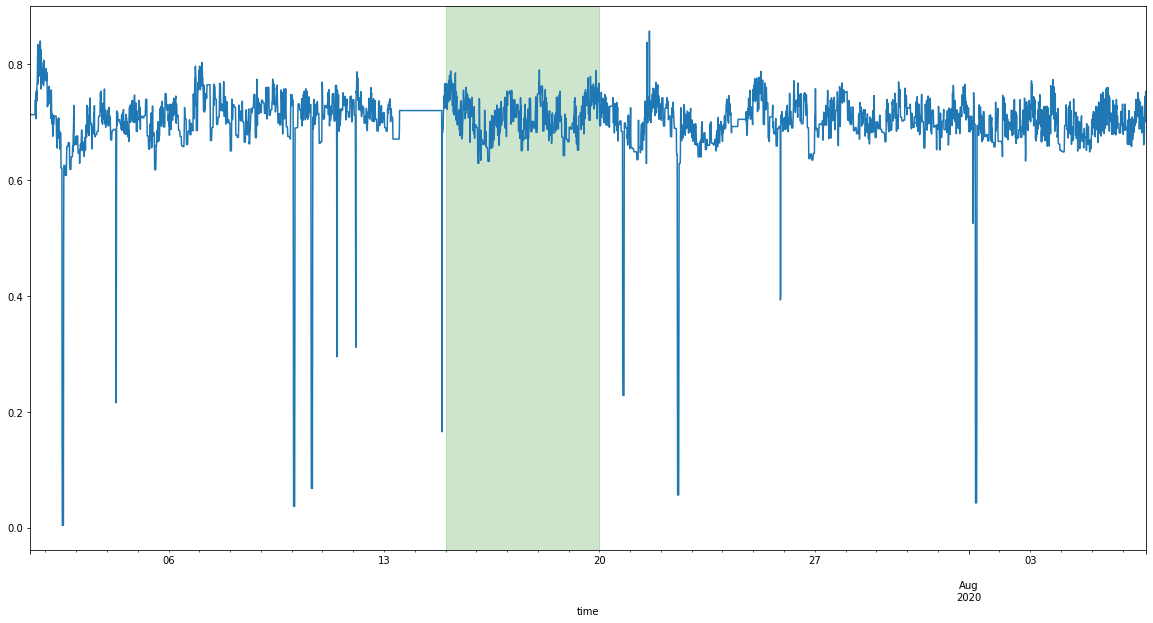

In [96]:
df_regular["Value"].plot(figsize=(20,10))
from_span = pd.to_datetime("2020-07-15 00:00:00", utc=True)
to_span = pd.to_datetime("2020-07-20 00:00:00", utc=True)
plt.axvspan(from_span, to_span, color="g", alpha=0.2)

The objective would be to compare each subsequence and determine their minimum distance

![](https://people.cs.kuleuven.be/wannes.meert/dtw/dtw_example.png?v=5)

In this example, we're using Dynamic Time Warping (DTW) to find the minimum distance. This method allows for variable lengthed
sequences by "warping" the comparing sequences to find the minimum distance.

![](https://people.cs.kuleuven.be/wannes.meert/dtw/warping_paths.png?v=3)

In [97]:
ts_desired = df_regular[(df_regular["time"] >= from_span) & (df_regular["time"] < to_span)]["Value"].values
window = len(ts_desired)

In [98]:
# Divide series into subsequences to compare against desired sequence
ts_series = df_regular["Value"].values
len_series = len(ts_series)

sample_rate = 12 # Sample every two hours, i.e. 12 * 10-minute inverval = 120 minutes)

ts_matrix = [ts_series[i:i+window] for i in range(0, len_series-window, sample_rate)]
ts_daterange = [(df_regular["time"][i], df_regular["time"][i+window]) for i in range(0, len_series-window, sample_rate)]
ts_matrix = np.array(ts_matrix)
ts_matrix.shape

(376, 720)

In [124]:
ts_daterange[:2]

[(Timestamp('2020-07-01 12:00:00+0000', tz='UTC'),
  Timestamp('2020-07-06 12:00:00+0000', tz='UTC')),
 (Timestamp('2020-07-01 14:00:00+0000', tz='UTC'),
  Timestamp('2020-07-06 14:00:00+0000', tz='UTC'))]

In [99]:
# Running the full matrix will return all subsequnces against itself (cpu intensive)
start_time = time.time()

dist_matrix = dtw.distance_matrix_fast(ts_matrix)

print("Execution time: {}s".format(time.time() - start_time))

Execution time: 19.69292664527893s


In [100]:
pd.DataFrame(dist_matrix)

,0,1,2,3,4,5,6,7,8,9,...,366,367,368,369,370,371,372,373,374,375
0,inf,0.13635,0.144526,0.346726,0.372673,0.359249,0.475704,0.583981,0.478403,0.714082,...,0.871160,0.864238,0.873893,2.101762,1.800697,1.804575,1.810350,1.805107,1.797036,1.799177
1,inf,inf,0.062729,0.258201,0.290570,0.304720,0.387831,0.428132,0.453518,0.690821,...,0.863428,0.862331,0.872730,2.101070,1.799965,1.800477,1.799770,1.800082,1.794732,1.793451
2,inf,inf,inf,0.163883,0.220414,0.247751,0.351502,0.506518,0.484164,0.718735,...,0.866113,0.863289,0.869334,2.112328,1.800032,1.800686,1.802419,1.801517,1.796323,1.796491
3,inf,inf,inf,inf,0.095565,0.231457,0.300938,0.461580,0.500699,0.704640,...,0.942598,0.909827,0.862311,2.193292,1.802546,1.834763,1.823245,1.863069,1.835105,1.843193
4,inf,inf,inf,inf,inf,0.142522,0.186814,0.298461,0.336984,0.521583,...,0.910129,0.883720,0.829685,2.189716,1.783249,1.807490,1.795015,1.827532,1.803464,1.812698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,0.094044,0.116814,0.144555,0.176853
372,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,0.066612,0.105594,0.145087
373,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,0.124618,0.129432
374,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,0.068168


In [101]:
# Append the desired sequence to the end of the full matrix
ts_matrix = np.append(ts_matrix, ts_desired).reshape(ts_matrix.shape[0] + 1, ts_matrix.shape[1])

In [102]:
# Calculate Distance matrix for only the desired sequence
start_time = time.time()

dist_matrix = dtw.distance_matrix_fast(
    ts_matrix,
    block=((0, len(ts_matrix)), (len(ts_matrix)-1, len(ts_matrix)))
    )

print("Execution time: {}s".format(time.time() - start_time))

Execution time: 0.16800951957702637s


In [103]:
pd.DataFrame(dist_matrix)

,0,1,2,3,4,5,6,7,8,9,...,367,368,369,370,371,372,373,374,375,376
0,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,1.764614
1,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,1.750465
2,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,1.759118
3,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,1.761218
4,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,1.744490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,0.526823
373,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,0.579975
374,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,0.546833
375,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,0.549502


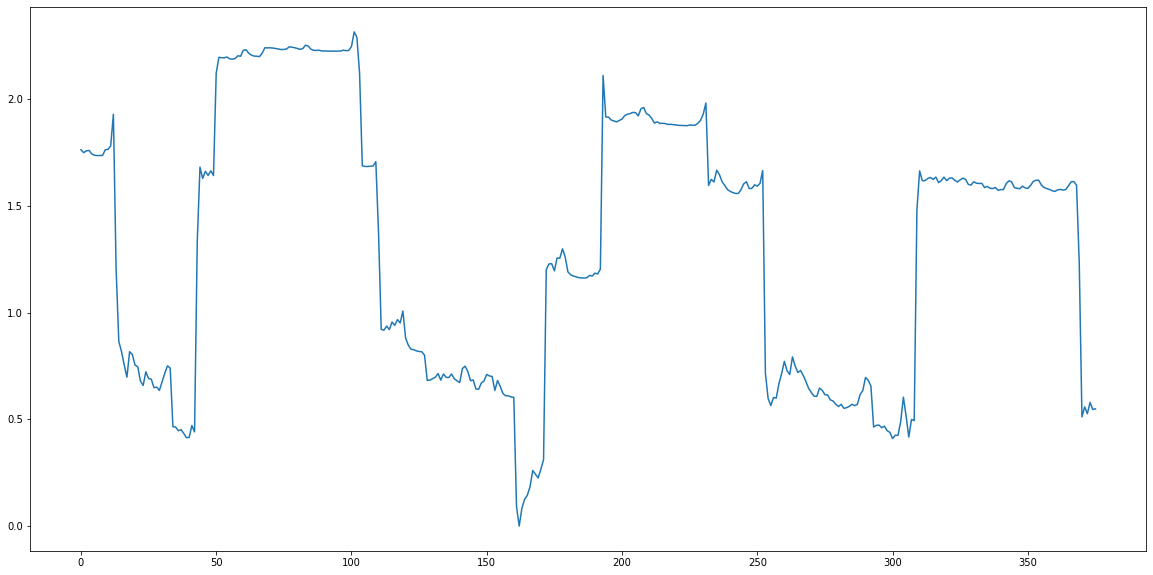

In [104]:
dist = pd.DataFrame(dist_matrix).iloc[:-1, -1].dropna()
dist.plot(figsize=(20,10))

## Nearest Neighbor Distances

In [105]:
from sklearn.cluster import KMeans

In [118]:
km = KMeans(5)
cluster_index = km.fit_predict(dist.values.reshape(-1, 1))
desired_cluster = cluster_index[dist[dist == 0].index[0]]

print("Desired sequence is in cluster: {}".format(desired_cluster))

Desired sequence is in cluster: 0


In [119]:
desired_sequence_index = np.where(cluster_index == desired_cluster)[0]

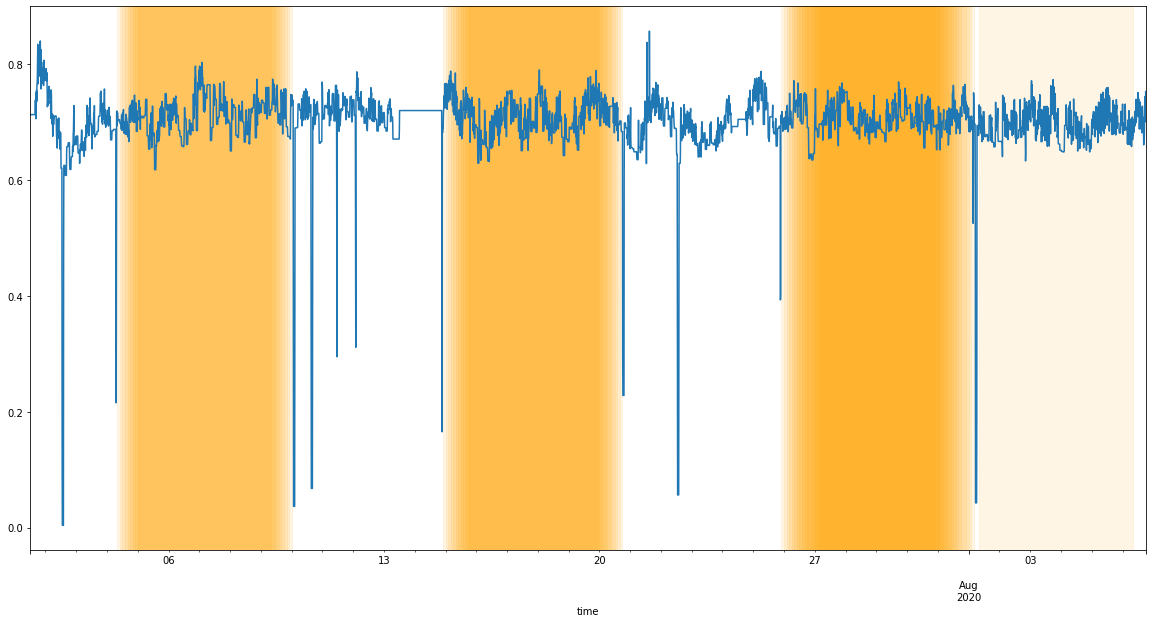

In [121]:
df_regular["Value"].plot(figsize=(20,10))

for i in desired_sequence_index:
    from_span = ts_daterange[i][0]
    to_span = ts_daterange[i][1]
    plt.axvspan(from_span, to_span, color="orange", alpha=0.1)